conda 환경설정 확인

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("torch-cuda:", torch.version.cuda)
print(torch.cuda.get_device_name(0))


jpg -> zarr 변환 및 검증

In [1]:
# ▶︎ 셀 0 : PYTHONPATH에 'src' 추가
import sys, pathlib

# notebooks/…/preprocessing.ipynb 기준으로 프로젝트 루트 계산
NB_PATH       = pathlib.Path.cwd()
PROJECT_ROOT  = NB_PATH.parent          # byu-motor/
SRC_PATH      = PROJECT_ROOT / "src"    # byu-motor/src

# src 를 import 경로 맨 앞에 삽입
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))
    print("PYTHONPATH +", SRC_PATH)

# 패키지 초기화 파일이 없으면 생성(한 번만)
(SRC_PATH / "__init__.py").touch(exist_ok=True)
(SRC_PATH / "data" / "__init__.py").touch(exist_ok=True)


PYTHONPATH + d:\project\Kaggle\BYU\byu-motor\src


In [2]:
# ▶︎ 셀 1 : 경로·옵션 지정 (필요에 따라 수정)
RAW_ROOT   = "../data/raw"              # train, test, train_labels.csv 위치
OUT_ROOT   = "../data/processed/zarr"   # 변환된 .zarr 저장 폴더
UNDERSAMPLE = 1                         # 1 → 모든 slice, 2 → 절반만
DTYPE       = "uint8"                   # uint8 | uint16 | float16
OVERWRITE   = False                     # 기존 .zarr 덮어쓰기 여부


In [3]:
# ▶︎ 셀 2 : JPEG → Zarr 변환 (스트리밍, 메모리 안전)
import pathlib, numpy as np, gc, importlib
from tqdm.notebook import tqdm

# prepare_data 모듈 함수 가져오기
prepare = importlib.import_module("data.prepare_data")
load_shape_dict = prepare.load_shape_dict
build_zarr      = prepare.build_zarr          # 스트리밍 버전

RAW_DIR = pathlib.Path(RAW_ROOT)
OUT_DIR = pathlib.Path(OUT_ROOT)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# train_labels.csv 로부터 (Z,Y,X) 기대 shape 딕셔너리
shape_dict = load_shape_dict(RAW_DIR / "train_labels.csv")

for split in ["train", "test"]:
    in_split  = RAW_DIR / split
    out_split = OUT_DIR / split
    if not in_split.exists():
        continue
    out_split.mkdir(parents=True, exist_ok=True)

    for tomo in tqdm(sorted(d.name for d in in_split.iterdir() if d.is_dir()),
                     desc=f"[{split}] convert"):
        jpeg_dir = in_split / tomo
        zarr_fp  = out_split / f"{tomo}.zarr"
        if zarr_fp.exists() and not OVERWRITE:
            continue
        build_zarr(
            jpeg_dir  = jpeg_dir,
            out_path  = zarr_fp,
            exp_shape = shape_dict.get(tomo),
            step      = UNDERSAMPLE,
            dtype     = np.dtype(DTYPE)
        )
        gc.collect()


[train] convert:   0%|          | 0/648 [00:00<?, ?it/s]

tomo_003acc: 400/500
tomo_003acc saved: (500, 1912, 1847) 
tomo_00e047: 200/300
tomo_00e047 saved: (300, 959, 928) 
tomo_00e463: 400/500
tomo_00e463 saved: (500, 924, 956) 
tomo_01a877: 200/300
tomo_01a877 saved: (300, 960, 928) 
tomo_02862f: 200/300
tomo_02862f saved: (300, 959, 928) 
tomo_0308c5: 200/300
tomo_0308c5 saved: (300, 960, 928) 
tomo_0333fa: 200/300
tomo_0333fa saved: (300, 960, 928) 
tomo_033ebe: 200/300
tomo_033ebe saved: (300, 960, 928) 
tomo_03437b: 200/300
tomo_03437b saved: (300, 959, 928) 
tomo_0363f2: 200/300
tomo_0363f2 saved: (300, 960, 928) 
tomo_040b80: 500/600
tomo_040b80 saved: (600, 928, 960) 
tomo_049310: 400/500
tomo_049310 saved: (500, 924, 956) 
tomo_04d42b: 400/500
tomo_04d42b saved: (500, 1024, 1440) 
tomo_05b39c: 700/800
tomo_05b39c saved: (800, 928, 960) 
tomo_05df8a: 200/300
tomo_05df8a saved: (300, 928, 928) (T)
tomo_05f919: 200/300
tomo_05f919 saved: (300, 959, 928) 
tomo_066095: 200/300
tomo_066095 saved: (300, 960, 928) 
tomo_06e11e: 200/300
tom

[test] convert:   0%|          | 0/3 [00:00<?, ?it/s]

tomo_003acc: 400/500
tomo_003acc saved: (500, 1912, 1847) 
tomo_00e047: 200/300
tomo_00e047 saved: (300, 959, 928) 
tomo_01a877: 200/300
tomo_01a877 saved: (300, 960, 928) 


In [4]:
# ▣ 셀 3 ─ 변환 결과 빠르게 점검
import glob, zarr, numpy as np, random

paths = glob.glob(f"{OUT_ROOT}/train/*.zarr")
print("변환된 train tomogram 수  :", len(paths))

sample = random.choice(paths)
arr = zarr.open(sample)[...]
print("예시", pathlib.Path(sample).name, arr.shape, arr.dtype)


변환된 train tomogram 수  : 648
예시 tomo_2c9f35.zarr (300, 960, 928) uint8


In [5]:
# ▣ 셀 4 ─ 축·좌표 검증
import pandas as pd, zarr, pathlib, numpy as np

# 1) CSV 로드 & 기대 shape 사전
csv = pd.read_csv(f"{RAW_ROOT}/train_labels.csv")
csv.columns = csv.columns.str.strip()

shape_dict = (csv
    .drop_duplicates("tomo_id")[["tomo_id",
                                 "Array shape (axis 0)",
                                 "Array shape (axis 1)",
                                 "Array shape (axis 2)"]]
    .set_index("tomo_id")
    .astype(int)
    .to_dict("index"))

# 2) 검증 루프
mismatch = []      # shape 불일치
coord_err = []     # 좌표가 범위 밖
for zfp in pathlib.Path(f"{OUT_ROOT}/train").glob("*.zarr"):
    tomo = zfp.stem
    vol = zarr.open(zfp, mode='r')
    Z, Y, X = vol.shape
    exp = shape_dict.get(tomo)
    if not exp:
        continue
    if (Y, X) != (exp["Array shape (axis 1)"], exp["Array shape (axis 2)"]):
        mismatch.append((tomo, vol.shape, exp))

    # 좌표 유효성 점검 (모터 행만)
    sub = csv[(csv.tomo_id == tomo) & (csv["Motor axis 0"] >= 0)]
    if not sub.empty:
        z_ok = ((sub["Motor axis 0"] < Z) & (sub["Motor axis 0"] >= 0)).all()
        y_ok = ((sub["Motor axis 1"] < Y) & (sub["Motor axis 1"] >= 0)).all()
        x_ok = ((sub["Motor axis 2"] < X) & (sub["Motor axis 2"] >= 0)).all()
        if not (z_ok and y_ok and x_ok):
            coord_err.append(tomo)

print(f"Shape mismatch tomograms : {len(mismatch)}")
print(f"Out-of-bound coords      : {len(coord_err)}")
if mismatch:
    for t, sh, exp in mismatch[:5]:
        print(f"  {t}: actual {sh} vs expected {exp}")


Shape mismatch tomograms : 0
Out-of-bound coords      : 0


(-0.5, 958.5, 926.5, -0.5)

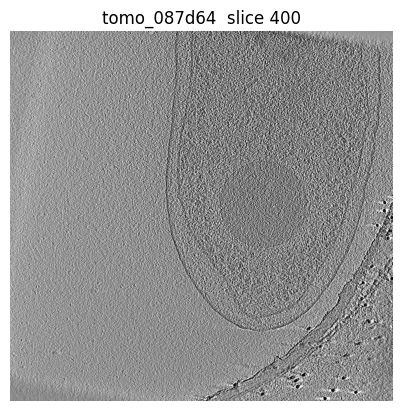

In [14]:
import matplotlib.pyplot as plt
import random

tomo = random.choice(list(shape_dict.keys()))
zp   = pathlib.Path(f"{OUT_ROOT}/train/{tomo}.zarr")
vol  = zarr.open(zp, 'r')
mid  = vol.shape[0] // 2

plt.imshow(vol[mid], cmap='gray')
plt.title(f"{tomo}  slice {mid}")
plt.axis('off')

In [3]:
from tqdm.auto import tqdm, trange
import cv2, numpy as np, glob, zarr, statistics as st

ratios = []
for zf in tqdm(glob.glob(f"{OUT_ROOT}/train/*.zarr")):
    vol = zarr.open(zf, mode='r')
    # 슬라이스마다 non-zero 픽셀 projection 후 bounding box 계산
    r = []
    for z in range(0, vol.shape[0], max(1, vol.shape[0]//20)):  # 5% 샘플
        img = vol[z]
        _, th = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
        coords = np.column_stack(np.where(th > 0))
        if coords.size:
            (y0,x0),(y1,x1) = coords.min(0), coords.max(0)
            r.append((y1-y0) / max(1, x1-x0))
    if r: ratios.append(np.mean(r))

print("평균 H/W :", np.mean(ratios),  "  표준편차 :", np.std(ratios))


  0%|          | 0/648 [00:00<?, ?it/s]

평균 H/W : 1.00315834031044   표준편차 : 0.05730592866793892
